# 루브릭
|평가문항|상세기준|self check|
|:-------|:-------|:-----------------------|
|1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.|데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.|OK|
|2. Transformer 번역기 모델이 정상적으로 구동된다.|Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.|OK|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.|OK|

### dataset
1.[한영 병렬 데이터](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)
### 적용할 알고리즘
1. SentencePiece
2. Transformer

## 문제 정의  

> Transformer로 한영 번역기 만들기

## 분석환경

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Image
#Image(filename='optimizer.png') 

In [2]:
import tensorflow
import numpy
import matplotlib

print(tensorflow.__version__)
print(numpy.__version__)
print(matplotlib.__version__)

2.6.0
1.21.4
3.4.3


In [3]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.6.0


#### Attention Map 확인위해 한글어를 지원하는 폰트로 변경

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

## Step 1. 데이터 다운로드

* [한영 병렬 데이터](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

## Step 2. 데이터 정제 및 토큰화

### 1. 중복 제거
* set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거
* 데이터의 병렬 쌍이 흐트러지지 않게 주의! 
* 중복을 제거한 데이터를 cleaned_corpus 에 저장

In [5]:
kor_path = "./data/korean-english-park.train.ko"
eng_path = "./data/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: 
        kor = f.read().splitlines()
    with open(eng_path, "r") as f: 
        eng = f.read().splitlines()
    
    assert len(kor) == len(eng)
    
    corpus = list(zip(kor,eng))
    cleaned_corpus = list(set(corpus))
    print("corpus size",len(corpus))
    print("cleaned_corpus size",len(cleaned_corpus))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

corpus size 94123
cleaned_corpus size 78968


In [6]:
cleaned_corpus[:5]

[('이것은 각기 다른 교육 수준(즉, 무학력, 초등 교육, 중등 교육, 고등 교육)을 이수한 25세 이상의 남녀 비율을 계산해 낸 것이다.',
  'This calculated the proportion of men and women over 25 who had completed different levels of schooling (ie, none;'),
 ('오크 그로브 학교 교장인 모건 포니스 씨는 학교에 물이 밀려들어오는 것을 막을 방법이 거의 없었다고 전했습니다.',
  "Oak Grove School principal, Morgan Forness, says there is little that could've been done to keep the water out of the buildings:"),
 ('권터 플라터 오스트리아 내무부장관은 7일 (현지 시간) 기자들에게 "이번 사건은 오스트리아에서 적발된 최대 포르노 유통 사건이다.',
  '"This is the biggest case of child porn distribution ever discovered in Austria," Interior Minister Guenther Platter told reporters on Wednesday.'),
 ('미 하원 금융위원회 위원장 바니 프랭크는, 많은 의원들이 논란이 있는 7000억 달러 구제 금융 법안에 투표하느니 차라리 당장 있을 재선에 대비해 선거 운동을 하는 편이 나을 것이라고 속내를 비췄습니다.',
  'House Financial Services Committee Chairman Barney Frank says frankly, many Congress members would rather be campaigning for reelection right now than casting a controversial vote on the $700 billion bailout deal.'),
 ('• 금연법은 간접 흡연 노출에 직접적인 감

### 2. 정제 함수를 아래 조건을 만족하게 정의하기
 * 모든 입력을 소문자로 변환
 * 알파벳, 문장부호, 한글만 남기고 모두 제거
 * 문장부호 양옆에 공백을 추가
 * 문장 앞뒤의 불필요한 공백을 제거

In [7]:
import re
def preprocess_sentence(sentence):

    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    #sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", " ", sentence)
    #sentence = re.sub(r"[^가-힣a-zA-Z1-9?.!, ]+", "", sentence)
    sentence = re.sub(r"[^가-힣a-zA-Z?.!, ]+", "", sentence)

    sentence = sentence.strip()

    return sentence

preprocess_sentence('ABC DCF 12345안녕하세요? 만ㅠㅠㅠㅠㅠㅠ나서 ㅎㅎㅋㅋㅋㅋㅋㅋ유ㅏㄴ ㅏ')

'abc dcf 안녕하세요 ? 만나서 유'

### 3. SentencePiece로 토큰화하기 
* 토큰화에는 Sentencepiece 활용.  
  * 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화 진행  
* generate_tokenizer() 함수 정의하기
  > * 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의 (기본: 20,000)
  > * 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환
  > * 특수 토큰의 인덱스를 아래와 동일하게 지정
  > \<PAD> : 0 / \<BOS> : 1 / \<EOS> : 2 / \<UNK> : 3
* 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻기 
  > * en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 구현

In [9]:
import sentencepiece as spm

#### sentencepiece 모델 생성

In [10]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):

    
    if(lang == "ko"):
        input_file = './sp_tokenizer/kor_corpus.txt'
        model_prefix = 'kor_20000_spm' 
        
        with open(input_file, 'w', encoding='utf8') as f:
            for row in corpus:   # 이전 스텝에서 정제했던 kor_corpus를 활용
                f.write(str(row) + '\n')
        
    
    if(lang == "en"):
        input_file = './sp_tokenizer/eng_corpus.txt'
        model_prefix = 'eng_20000_spm'
        
        with open(input_file, 'w', encoding='utf8') as f:
            for row in corpus:   # 이전 스텝에서 정제했던 eng_corpus를 활용.
                f.write(str(row) + '\n')
       

    model_type = 'unigram'
    
    templates = '--input={} \
                     --model_prefix={} \
                     --vocab_size={} \
                     --model_type={} \
                     --pad_id={} --pad_piece=[PAD] \
                     --bos_id={} --bos_piece=[BOS] \
                     --eos_id={} --eos_piece=[EOS] \
                     --unk_id={} --unk_piece=[UNK]'
        
    cmd = templates.format(input_file, model_prefix, vocab_size, model_type, pad_id, bos_id, eos_id, unk_id)

    
    spm.SentencePieceTrainer.Train(cmd)    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('{}.model'.format(model_prefix))    

    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

kor_corpus = []
eng_corpus = []

for kor, eng in cleaned_corpus:
    kor_corpus.append(preprocess_sentence(kor))
    eng_corpus.append(preprocess_sentence(eng))

print("Korean:", kor_corpus[0])   
print("English:", eng_corpus[0])  

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

Korean: 이것은 각기 다른 교육 수준즉 , 무학력 , 초등 교육 , 중등 교육 , 고등 교육을 이수한 세 이상의 남녀 비율을 계산해 낸 것이다 .
English: this calculated the proportion of men and women over  who had completed different levels of schooling ie , none


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=./sp_tokenizer/kor_corpus.txt                      --model_prefix=kor_20000_spm                      --vocab_size=20000                      --model_type=unigram                      --pad_id=0 --pad_piece=[PAD]                      --bos_id=1 --bos_piece=[BOS]                      --eos_id=2 --eos_piece=[EOS]                      --unk_id=3 --unk_piece=[UNK]
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./sp_tokenizer/kor_corpus.txt
  input_format: 
  model_prefix: kor_20000_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  tr

True

#### 이미 만들어진 SentencePiece 모델 사용

In [11]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    if(lang == "ko"):
        model_prefix = 'kor_20000_spm'      
    
    if(lang == "en"):
        model_prefix = 'eng_20000_spm'
   
    #spm.SentencePieceTrainer.Train(cmd)    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('{}.model'.format(model_prefix))    

    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

kor_corpus = []
eng_corpus = []

for kor, eng in cleaned_corpus:
    kor_corpus.append(preprocess_sentence(kor))
    eng_corpus.append(preprocess_sentence(eng))

print("Korean:", kor_corpus[0])   
print("English:", eng_corpus[0])  

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

Korean: 이것은 각기 다른 교육 수준즉 , 무학력 , 초등 교육 , 중등 교육 , 고등 교육을 이수한 세 이상의 남녀 비율을 계산해 낸 것이다 .
English: this calculated the proportion of men and women over  who had completed different levels of schooling ie , none


True

In [12]:
ko_tokenizer.GetPieceSize()
en_tokenizer.GetPieceSize()

20000

20000

In [13]:
ko_tokenizer.IdToPiece(2)
ko_tokenizer.PieceToId('[PAD]')

'[EOS]'

0

In [14]:
print(kor_corpus[0])
print(ko_tokenizer.encode_as_pieces(kor_corpus[0]))
print(ko_tokenizer.encode_as_ids(kor_corpus[0]))

이것은 각기 다른 교육 수준즉 , 무학력 , 초등 교육 , 중등 교육 , 고등 교육을 이수한 세 이상의 남녀 비율을 계산해 낸 것이다 .
['▁이것', '은', '▁각', '기', '▁다른', '▁교육', '▁수준', '즉', '▁,', '▁무', '학', '력', '▁,', '▁초', '등', '▁교육', '▁,', '▁중', '등', '▁교육', '▁,', '▁고등', '▁교육', '을', '▁이', '수', '한', '▁세', '▁이상의', '▁남녀', '▁비율', '을', '▁계산', '해', '▁낸', '▁것이다', '▁.']
[1218, 9, 892, 65, 73, 1035, 1038, 19739, 12, 513, 1192, 749, 12, 312, 1619, 1035, 12, 58, 1619, 1035, 12, 10887, 1035, 5, 19, 171, 18, 106, 694, 6822, 4639, 5, 5642, 57, 3278, 113, 4]


In [15]:
print(eng_corpus[0])
print(en_tokenizer.encode_as_pieces(eng_corpus[0]))
print(en_tokenizer.encode_as_ids(eng_corpus[0]))

this calculated the proportion of men and women over  who had completed different levels of schooling ie , none
['[BOS]', '▁this', '▁calculat', 'ed', '▁the', '▁proportion', '▁of', '▁men', '▁and', '▁women', '▁over', '▁who', '▁had', '▁complet', 'ed', '▁different', '▁levels', '▁of', '▁school', 'ing', '▁i', 'e', '▁,', '▁none', '[EOS]']
[1, 51, 9148, 11, 4, 8545, 10, 337, 13, 291, 74, 45, 48, 2794, 11, 786, 1488, 10, 392, 14, 61, 43, 6, 2492, 2]


### 4. 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환하기 
(❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)


In [16]:
import tensorflow as tf
#from tqdm.notebook import tqdm    # Process 과정을 보기 위해
from tqdm import tqdm

src_corpus = []
tgt_corpus = []
sequence_len = 50 #토큰 길이

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    if (len(ko_tokenizer.EncodeAsIds(kor_corpus[idx])) <= sequence_len) & (len(en_tokenizer.EncodeAsIds(eng_corpus[idx])) <= sequence_len): 
        src_corpus.append(ko_tokenizer.encode_as_ids(kor_corpus[idx]))
        tgt_corpus.append(en_tokenizer.encode_as_ids(eng_corpus[idx]))
        

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_tensor = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_tensor = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("Korean Vocab Size:", ko_tokenizer.GetPieceSize())
print("English Vocab Size:", en_tokenizer.GetPieceSize())

100%|██████████| 78968/78968 [00:08<00:00, 9805.93it/s] 


Korean Vocab Size: 20000
English Vocab Size: 20000


In [17]:
enc_train.shape
enc_val.shape
enc_train[0]
enc_val[0]
dec_train[0]

(58705, 50)

(14677, 50)

array([14063,     7,    97,   245,     6,   147,  1349,    12,  2578,
          12,  2788,   118,   145,  2706, 10475,   829,     8, 11953,
          15,   356,    36,  2894,  7257,  9211,   178, 10475,   829,
           8,  6019,   348,   353,  1268,   244,     8,  2530,    30,
          48,    27,     4,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

array([13559,    14,  3193, 15371,    21,  7967,   398,   172,     7,
        2135,  2444,   619,     5,    25,    32,   770,    21, 15942,
           4,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

array([    1,   229,    31,    50,   728,     8, 11339,     4, 16526,
          12,     4,    75,   383,  3136,     6,    23,    18,  1015,
           6,  1514,    13,   284,  1505,     6,  4440,    32,    15,
           5,   116,    70,    31,     8,   470,     8,   167,    19,
       11339,     4, 16526,    10,    51,   613,    21,    60,   799,
        4631,     5,     2,     0,     0], dtype=int32)

## Step 3. Transformer 모델 설계

### 1. 내부 모듈 구현

### Positional Encoding

In [18]:
#def positional_encoding(pos, d_model):
#    def cal_angle(position, i):
#        return position / np.power(10000, int(i) / d_model)
#
#    def get_posi_angle_vec(position):
#        return [cal_angle(position, i) for i in range(d_model)]
#
#    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
#    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
#    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
#    return sinusoid_table

In [19]:
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

### Multi-Head Attention

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
       
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

### Position-wise Feed-Forward Network

In [21]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

### 2. 모듈 조립

### Encoder 레이어 구현하기

In [22]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

### Decoder 레이어 구현하기

In [23]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### Encoder 모델 설계

In [24]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

### Decoder 모델 설계

In [25]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### Transformer 구조 설계

In [26]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

### Masking 

In [27]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    #print(tgt.shape, src.shape)
    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)
    
    #print(dec_enc_causality_mask,dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

## Step 4. 훈련하기

### 1. 2 Layer를 가지는 Transformer를 선언하기
* 하이퍼파라미터는 자유롭게 조절

#### 시도 1

In [29]:
# Hyperparameters
n_layers = 2
d_model = 512 
n_heads = 8 
d_ff = 2048
src_vocab_size = SRC_VOCAB_SIZE # 20000
tgt_vocab_size = TGT_VOCAB_SIZE # 20000
pos_len = sequence_len # 50
dropout = 0.1


transformer = Transformer(
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout
                    )

#transformer.summary()

#### 시도 2

In [28]:
# Hyperparameters
n_layers = 2
d_model = 512 
n_heads = 8 
d_ff = 2048
src_vocab_size = SRC_VOCAB_SIZE # 20000
tgt_vocab_size = TGT_VOCAB_SIZE # 20000
pos_len = sequence_len # 50
dropout = 0.1


transformer = Transformer(
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout
                    )

#transformer.summary()

#### 시도 3

In [56]:
# Hyperparameters
n_layers = 2
d_model = 512 
n_heads = 8 
d_ff = 2048
src_vocab_size = SRC_VOCAB_SIZE # 20000
tgt_vocab_size = TGT_VOCAB_SIZE # 20000
pos_len = sequence_len # 50
dropout = 0.3


transformer = Transformer(
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout
                    )

#transformer.summary()

### Learning Rate Scheduler & Adam Optimizer 선언
* 논문과 동일하게 설정

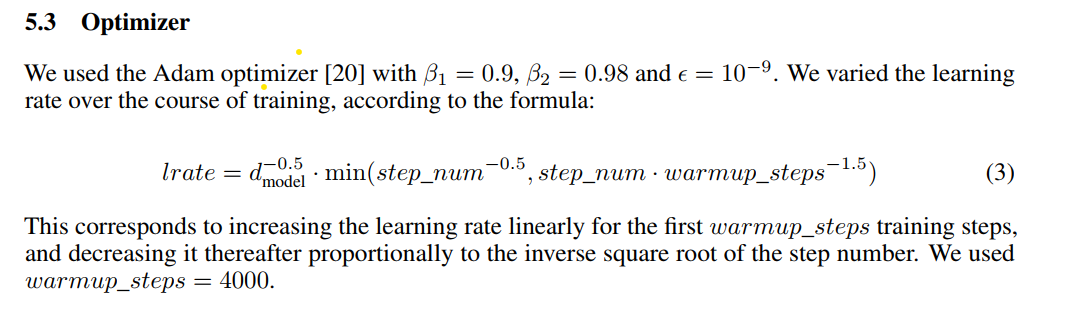

In [30]:
Image(filename='./data/optimizer.png') 

In [31]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [32]:
# de_model = 512
learning_rate = LearningRateScheduler(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

### 3. Loss 함수를 정의하세요.  
Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [33]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### 4. train_step 함수를 정의
* 입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 하기

In [34]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
    
    #print(tgt.shape, gold.shape)
    #print("tgt: ",tgt, "gold", gold)
    #print()
    #print("gold: ", gold)
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])
        
        #print(predictions.shape,predictions[:, :-1].shape )
        #print("predictions::::",predictions )
        #print()
        #print("predictions-1::::",predictions[:, :-1] )

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
       
    return loss, enc_attns, dec_attns, dec_enc_attns

In [35]:
# Eval Step 함수 정의

@tf.function()
def eval_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    predictions, enc_attns, dec_attns, dec_enc_attns = \
    model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
    loss = loss_function(gold, predictions[:, :-1])
    
    return loss, enc_attns, dec_attns, dec_enc_attns


### 5. 학습 진행

* 매 Epoch 마다 제시된 예문에 대한 번역을 생성 
* 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 제출

**<예문>**
1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

**<결과>**
**Translations**
 1. obama is the president elect .
 2. they are in the city .
 3. they don t need to be a lot of drink .
 4. seven other people have been killed in the attacks .

**Hyperparameters**  
   n_layers: 2  
   d_model: 512  
   n_heads: 8  
   d_ff: 2048  
   dropout: 0.3  

**Training Parameters**  
 Warmup Steps: 4000  
 Batch Size: 64  
 Epoch At: 5  

In [36]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y,annot=True )
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [37]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [38]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

#### 시도 1

In [39]:
# 학습

#from tqdm.notebook import tqdm
from tqdm import tqdm

import random

BATCH_SIZE = 64
#EPOCHS = 20
#EPOCHS = 10
EPOCHS = 10

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]


# Hyperparameters
print(f"Hyperparameters \n \
      n_layers={n_layers} \n \
      d_model={d_model} \n \
      n_heads={n_heads} \n \
      d_ff={d_ff} \n \
      src_vocab_size={src_vocab_size} \n \
      tgt_vocab_size={tgt_vocab_size} \n \
      dropout={dropout}")

print(f"Training Parameters \n \
      Warmup Steps={4000} \n \
      BATCH_SIZE={BATCH_SIZE}")



for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    
    
    for (test_batch, idx) in enumerate(t):
        test_batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        eval_step(enc_val[idx:idx+BATCH_SIZE],
                    dec_val[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        test_loss += test_batch_loss
        
        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

        
    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)
        
    

Hyperparameters 
       n_layers=2 
       d_model=512 
       n_heads=8 
       d_ff=2048 
       src_vocab_size=20000 
       tgt_vocab_size=20000 
       dropout=0.1
Training Parameters 
       Warmup Steps=4000 
       BATCH_SIZE=64


Test Epoch  1: 100%|██████████| 230/230 [00:17<00:00, 13.49it/s, Test Loss 5.2128]


Input: 오바마는 대통령이다.
Predicted translation: obamas campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: the same of the worlds largest .
Input: 커피는 필요 없다.
Predicted translation: the dow is no .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deaths were injured .


Test Epoch  2: 100%|██████████| 230/230 [00:15<00:00, 14.45it/s, Test Loss 4.5624]


Input: 오바마는 대통령이다.
Predicted translation: obamas president .
Input: 시민들은 도시 속에 산다.
Predicted translation: theyre just a lot of people .
Input: 커피는 필요 없다.
Predicted translation: coffee is not a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sundays death toll was killed .


Test Epoch  3: 100%|██████████| 230/230 [00:15<00:00, 14.46it/s, Test Loss 4.3251]


Input: 오바마는 대통령이다.
Predicted translation: obamas campaigned in the first lady .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city city city city city .
Input: 커피는 필요 없다.
Predicted translation: the coffee is not a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


Test Epoch  4: 100%|██████████| 230/230 [00:15<00:00, 14.49it/s, Test Loss 4.2930]


Input: 오바마는 대통령이다.
Predicted translation: obama is a former president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the mountain is about the mountain .
Input: 커피는 필요 없다.
Predicted translation: no need is needed to be the united states .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death toll from the death toll .


Test Epoch  5: 100%|██████████| 230/230 [00:15<00:00, 14.48it/s, Test Loss 4.3437]


Input: 오바마는 대통령이다.
Predicted translation: obama is a former president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the city of chided .
Input: 커피는 필요 없다.
Predicted translation: the coffee chain has never asked .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday , a day of the deadly wounded .


Test Epoch  6: 100%|██████████| 230/230 [00:15<00:00, 14.43it/s, Test Loss 4.5837]


Input: 오바마는 대통령이다.
Predicted translation: obama is a very sorry .
Input: 시민들은 도시 속에 산다.
Predicted translation: the home is a city in the city .
Input: 커피는 필요 없다.
Predicted translation: no coffee is done .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll rose to .


Test Epoch  7: 100%|██████████| 230/230 [00:15<00:00, 14.42it/s, Test Loss 4.9897]


Input: 오바마는 대통령이다.
Predicted translation: obamas president , obama said .
Input: 시민들은 도시 속에 산다.
Predicted translation: they had just like the city .
Input: 커피는 필요 없다.
Predicted translation: there is no doubt coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: twelve deaths were dead monday .


Test Epoch  8: 100%|██████████| 230/230 [00:15<00:00, 14.44it/s, Test Loss 5.4908]


Input: 오바마는 대통령이다.
Predicted translation: obama is being held in the democratic presidential race .
Input: 시민들은 도시 속에 산다.
Predicted translation: .
Input: 커피는 필요 없다.
Predicted translation: thats needed a chain of coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: deaths civilian deaths have been .


Test Epoch  9: 100%|██████████| 230/230 [00:15<00:00, 14.46it/s, Test Loss 6.0524]


Input: 오바마는 대통령이다.
Predicted translation: obama is one of the presidents most democratic partys seeking a  ⁇ 
Input: 시민들은 도시 속에 산다.
Predicted translation: in one town , citizens in town .
Input: 커피는 필요 없다.
Predicted translation: thats needed u . n . coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: deaths in the southern dead were up to nine monday , seven other deaths occurred monday .


Test Epoch 10: 100%|██████████| 230/230 [00:15<00:00, 14.39it/s, Test Loss 6.5568]


Input: 오바마는 대통령이다.
Predicted translation: obama is expected to be president of the same kind of a very president , obamas a gave a massive set of his old trip to president barack obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: three cities
Input: 커피는 필요 없다.
Predicted translation: no doubts for us needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: deaths in the seven other deaths .


####  시도 2

In [38]:
# 학습

#from tqdm.notebook import tqdm
from tqdm import tqdm

import random

BATCH_SIZE = 64
#EPOCHS = 20
EPOCHS = 10
#EPOCHS = 1

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]


# Hyperparameters
print(f"Hyperparameters \n \
      n_layers={n_layers} \n \
      d_model={d_model} \n \
      n_heads={n_heads} \n \
      d_ff={d_ff} \n \
      src_vocab_size={src_vocab_size} \n \
      tgt_vocab_size={tgt_vocab_size} \n \
      pos_len = {pos_len} \n \
      dropout={dropout}")

print(f"Training Parameters \n \
      Warmup Steps={4000} \n \
      BATCH_SIZE={BATCH_SIZE}")



for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    
    
    for (test_batch, idx) in enumerate(t):
        test_batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        eval_step(enc_val[idx:idx+BATCH_SIZE],
                    dec_val[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        test_loss += test_batch_loss
        
        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

        
    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)
        
    

Hyperparameters 
       n_layers=2 
       d_model=512 
       n_heads=8 
       d_ff=2048 
       src_vocab_size=20000 
       tgt_vocab_size=20000 
       pos_len = 50 
       dropout=0.2
Training Parameters 
       Warmup Steps=4000 
       BATCH_SIZE=64


Test Epoch  1: 100%|██████████| 230/230 [00:17<00:00, 13.43it/s, Test Loss 5.2060]


Input: 오바마는 대통령이다.
Predicted translation: president roh moohyun .
Input: 시민들은 도시 속에 산다.
Predicted translation: the dow is a fewer .
Input: 커피는 필요 없다.
Predicted translation: theyre not to the economy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the blast was killed in the death toll .


Test Epoch  2: 100%|██████████| 230/230 [00:15<00:00, 14.47it/s, Test Loss 4.5541]


Input: 오바마는 대통령이다.
Predicted translation: obamas president roh has left his first time .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a small city .
Input: 커피는 필요 없다.
Predicted translation: theyre not just a good thing .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll .


Test Epoch  3: 100%|██████████| 230/230 [00:15<00:00, 14.47it/s, Test Loss 4.3140]


Input: 오바마는 대통령이다.
Predicted translation: obama is only picked up .
Input: 시민들은 도시 속에 산다.
Predicted translation: the streets are in cities .
Input: 커피는 필요 없다.
Predicted translation: coffees arent enough .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the number of deadly injured people .


Test Epoch  4: 100%|██████████| 230/230 [00:15<00:00, 14.45it/s, Test Loss 4.2794]


Input: 오바마는 대통령이다.
Predicted translation: i think that president obama is not the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of bear is so long .
Input: 커피는 필요 없다.
Predicted translation: no one is needed to be a good
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was not known .


Test Epoch  5: 100%|██████████| 230/230 [00:17<00:00, 12.95it/s, Test Loss 4.3250]


Input: 오바마는 대통령이다.
Predicted translation: obama is a good president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in urban city .
Input: 커피는 필요 없다.
Predicted translation: no one is needed to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll rose from the nearby fatality .


Test Epoch  6: 100%|██████████| 230/230 [00:15<00:00, 14.47it/s, Test Loss 4.5456]


Input: 오바마는 대통령이다.
Predicted translation: obama then took the first .
Input: 시민들은 도시 속에 산다.
Predicted translation: the town is happy .
Input: 커피는 필요 없다.
Predicted translation: it doesnt sound .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in the seven subway .


Test Epoch  7: 100%|██████████| 230/230 [00:15<00:00, 14.47it/s, Test Loss 4.9290]


Input: 오바마는 대통령이다.
Predicted translation: obama has picked up .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are no strangers in the north .
Input: 커피는 필요 없다.
Predicted translation: it is not needed for an average woman needed
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least seven people have been killed since the attack began .


Test Epoch  8: 100%|██████████| 230/230 [00:15<00:00, 14.47it/s, Test Loss 5.4544]


Input: 오바마는 대통령이다.
Predicted translation: obama has won the first .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are d happy .
Input: 커피는 필요 없다.
Predicted translation: it is the place for where theyre needs to live .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven deaths were on wednesday .


Test Epoch  9: 100%|██████████| 230/230 [00:15<00:00, 14.42it/s, Test Loss 6.0397]


Input: 오바마는 대통령이다.
Predicted translation: obama may have kind of appalling
Input: 시민들은 도시 속에 산다.
Predicted translation: they took a d . d . c .
Input: 커피는 필요 없다.
Predicted translation: no need to be required .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other deaths were hit .


Test Epoch 10: 100%|██████████| 230/230 [00:15<00:00, 14.43it/s, Test Loss 6.5335]


Input: 오바마는 대통령이다.
Predicted translation: obama has .
Input: 시민들은 도시 속에 산다.
Predicted translation: they have a small in town .
Input: 커피는 필요 없다.
Predicted translation: no one needs to be needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven deaths were recorded .


#### 시도 3

In [66]:
# 학습

#from tqdm.notebook import tqdm
from tqdm import tqdm
import random

BATCH_SIZE = 64
#EPOCHS = 20
EPOCHS = 10
#EPOCHS = 1

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]


# Hyperparameters
print(f"Hyperparameters \n \
      n_layers={n_layers} \n \
      d_model={d_model} \n \
      n_heads={n_heads} \n \
      d_ff={d_ff} \n \
      src_vocab_size={src_vocab_size} \n \
      tgt_vocab_size={tgt_vocab_size} \n \
      dropout={dropout}")

print(f"Training Parameters \n \
      Warmup Steps={4000} \n \
      BATCH_SIZE={BATCH_SIZE}")



for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    
    
    for (test_batch, idx) in enumerate(t):
        test_batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        eval_step(enc_val[idx:idx+BATCH_SIZE],
                    dec_val[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        test_loss += test_batch_loss
        
        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

        
    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)
        

Hyperparameters 
       n_layers=2 
       d_model=512 
       n_heads=8 
       d_ff=2048 
       src_vocab_size=20000 
       tgt_vocab_size=20000 
       dropout=0.3
Training Parameters 
       Warmup Steps=4000 
       BATCH_SIZE=64


Test Epoch  1: 100%|██████████| 230/230 [00:17<00:00, 13.50it/s, Test Loss 5.2119]


Input: 오바마는 대통령이다.
Predicted translation: obamas obama says the president roh moohyun is now .
Input: 시민들은 도시 속에 산다.
Predicted translation: the dow is also the world .
Input: 커피는 필요 없다.
Predicted translation: the dow is not to youre .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead , the dead , the dead , the dead .


Test Epoch  2: 100%|██████████| 230/230 [00:15<00:00, 14.49it/s, Test Loss 4.5552]


Input: 오바마는 대통령이다.
Predicted translation: obamas president obamas obama is a obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city city of the city .
Input: 커피는 필요 없다.
Predicted translation: coffee is not a lot of coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: more than people were killed .


Test Epoch  3: 100%|██████████| 230/230 [00:15<00:00, 14.48it/s, Test Loss 4.3110]


Input: 오바마는 대통령이다.
Predicted translation: obamas president is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a major city .
Input: 커피는 필요 없다.
Predicted translation: if you dont have no one thing .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sundays death toll was killed .


Test Epoch  4: 100%|██████████| 230/230 [00:15<00:00, 14.50it/s, Test Loss 4.2738]


Input: 오바마는 대통령이다.
Predicted translation: obamas president elect barack obama will be the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are buried .
Input: 커피는 필요 없다.
Predicted translation: there are no shortages .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed in the death of a death in the southern territory .


Test Epoch  5: 100%|██████████| 230/230 [00:15<00:00, 14.51it/s, Test Loss 4.3305]


Input: 오바마는 대통령이다.
Predicted translation: obama also faces a first reaction to obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the man is a city of d wine .
Input: 커피는 필요 없다.
Predicted translation: for coffee is a coffee drink .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: four were killed in the incident .


Test Epoch  6: 100%|██████████| 230/230 [00:15<00:00, 14.50it/s, Test Loss 4.5477]


Input: 오바마는 대통령이다.
Predicted translation: obamas comments are the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the zone is a city of the city .
Input: 커피는 필요 없다.
Predicted translation: it needs to drink .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the clashes saturday .


Test Epoch  7: 100%|██████████| 230/230 [00:31<00:00,  7.20it/s, Test Loss 4.9536]


Input: 오바마는 대통령이다.
Predicted translation: obamas stump .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are worried about politicians .
Input: 커피는 필요 없다.
Predicted translation: it is necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven days later killed seven people .


Test Epoch  8: 100%|██████████| 230/230 [00:15<00:00, 14.47it/s, Test Loss 5.4873]


Input: 오바마는 대통령이다.
Predicted translation: obamas left for the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the neighbors are just a city .
Input: 커피는 필요 없다.
Predicted translation: for coffee , a stop you should stop take off .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .


Test Epoch  9: 100%|██████████| 230/230 [00:15<00:00, 14.45it/s, Test Loss 6.0338]


Input: 오바마는 대통령이다.
Predicted translation: obamas comments come on obamas amid his plan .
Input: 시민들은 도시 속에 산다.
Predicted translation: they spent on the cities .
Input: 커피는 필요 없다.
Predicted translation: the request is necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed , according to officials .


Test Epoch 10: 100%|██████████| 230/230 [00:15<00:00, 14.45it/s, Test Loss 6.5036]


Input: 오바마는 대통령이다.
Predicted translation: obamas grandmother dos face .
Input: 시민들은 도시 속에 산다.
Predicted translation: the zone is a chinese town of wine .
Input: 커피는 필요 없다.
Predicted translation: it needs to calm coffee do .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other missiles have been killed .


## 회고

* Attention Map 추가 시에 용량 초과로 인해, git hub에서 열리지 않아서, 삭제함
* 생성된 번역 및 하이퍼파라미터 

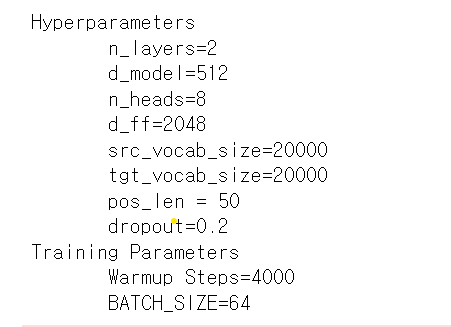

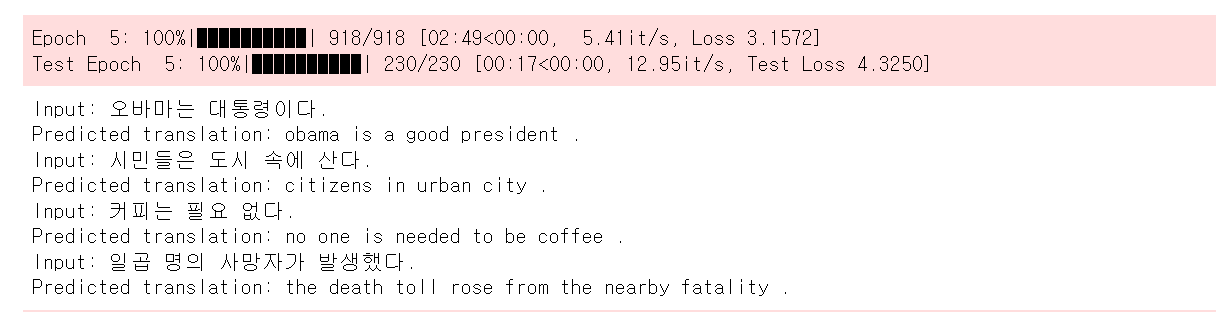

In [54]:
Image(filename='./data/gd10_2.png')
Image(filename='./data/gd10_1.png')

* Transformer 한영 번역기와 Attential seq2seq 한영 번역기 비교
  * 속도면에서는 확실히 rnn이 없어서 그런지 빠르다
  * 둘 다 번역이 생각했던거 만큼 잘 되는지 않지만, 트랜스포머의 경우는 문장은 번역이 완전하지 않지만, 확실히 문장 안의 단어는 정확하게 번역이 되는 편임 
  
* loss 의 의미
  * train loss는 epoch가 증가할 수록 감소하지만, test loss는 4.3 이하로는 떨어지지 않음.